<a href="https://colab.research.google.com/github/LeMat11/ME5920/blob/main/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Subset size: 1000
One sample shape: torch.Size([1, 28, 28]) label: 1


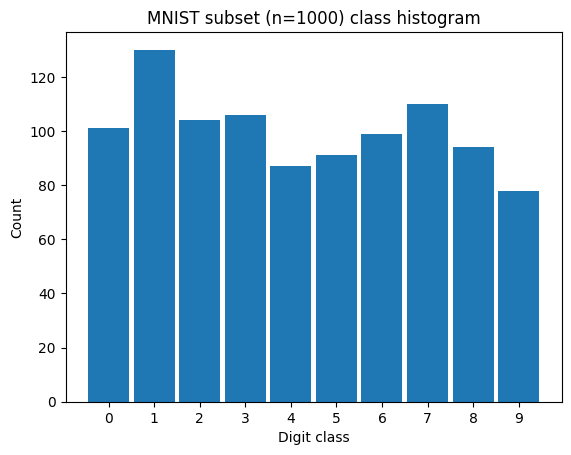

Batched images shape: torch.Size([40, 25, 1, 28, 28])
Batched labels shape: torch.Size([40, 25])


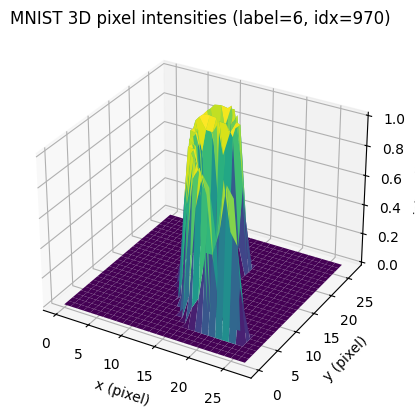

In [6]:
# 2.1 MNIST Images
# If needed (Colab): !pip -q install einops

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from einops import rearrange
import numpy as np

# ----------------------------
# 1) Download MNIST + subset of 1000
# ----------------------------
transform = transforms.ToTensor()  # returns tensor in [0,1], shape [1,28,28]

mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Make a deterministic subset of 1000 samples (optional but nice for reproducibility)
torch.manual_seed(11)
indices = torch.randperm(len(mnist_train))[:1000].tolist()
mnist_subset = Subset(mnist_train, indices)

print("Subset size:", len(mnist_subset))
x0, y0 = mnist_subset[0]
print("One sample shape:", x0.shape, "label:", y0)  # should be torch.Size([1,28,28])

# ----------------------------
# 2) Plot histogram of classes in subset
# ----------------------------
labels = [mnist_subset[i][1] for i in range(len(mnist_subset))]
plt.figure()
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.9)
plt.xticks(range(10))
plt.xlabel("Digit class")
plt.ylabel("Count")
plt.title("MNIST subset (n=1000) class histogram")
plt.show()

# ----------------------------
# 3) Batch images into groups of 25 using einops
#    Required shape: [1000,28,28] -> [num_batches, 25, 1, 28, 28]
# ----------------------------
# Stack subset into a single tensor
images = torch.stack([mnist_subset[i][0] for i in range(len(mnist_subset))])  # [1000,1,28,28]
labels_t = torch.tensor(labels)  # [1000]

# If you want the intermediate [1000,28,28] (as in prompt), squeeze channel then reshape back
images_1000_28_28 = images.squeeze(1)  # [1000,28,28]

# Make sure 1000 is divisible by 25
batch_size = 25
assert images_1000_28_28.shape[0] % batch_size == 0

# Rearrange to [num_batches, batch_size, 1, 28, 28]
batches = rearrange(images_1000_28_28, '(nb bs) h w -> nb bs 1 h w', bs=batch_size)
label_batches = rearrange(labels_t, '(nb bs) -> nb bs', bs=batch_size)

print("Batched images shape:", batches.shape)       # [40,25,1,28,28]
print("Batched labels shape:", label_batches.shape) # [40,25]

# ----------------------------
# 4) Randomly select an image and plot it in 3D
# ----------------------------
import random
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

idx = random.randint(0, len(mnist_subset)-1)
img, lab = mnist_subset[idx]  # img: [1,28,28]
img2d = img.squeeze(0).numpy()  # [28,28]

# Create x,y grid
x = np.arange(28)
y = np.arange(28)
X, Y = np.meshgrid(x, y)
Z = img2d  # pixel intensity

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')  # don't set colors per your default plotting preference
ax.set_xlabel("x (pixel)")
ax.set_ylabel("y (pixel)")
ax.set_zlabel("intensity")
ax.set_title(f"MNIST 3D pixel intensities (label={lab}, idx={idx})")
plt.show()


In [8]:
# =========================
# HW1 2.2 Time Series
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------- Load data -------------
csv_path = "energydata_complete.csv"  # adjust if your notebook is in a subfolder
df = pd.read_csv(csv_path)

# The dataset has a date column (usually named 'date')
# Convert to datetime and set as index for easy slicing
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")

# Appliances energy consumption column is typically named "Appliances"
energy = df["Appliances"]

print("Data time range:", df.index.min(), "to", df.index.max())
print("Sampling interval (first two rows):", df.index[1] - df.index[0])
print(df.head())

# ============= 1) Plot whole period + one week zoom =============
plt.figure()
plt.plot(energy.index, energy.values)
plt.xlabel("Time")
plt.ylabel("Appliances energy (Wh)")
plt.title("Appliances energy consumption (whole period)")
plt.show()

# Pick any one week to zoom (choose a start date you like)
# Here we auto-pick a week starting 30 days after the beginning to avoid edge effects
start_week = df.index.min() + pd.Timedelta(days=30)
end_week = start_week + pd.Timedelta(days=7)
energy_week = energy.loc[start_week:end_week]

plt.figure()
plt.plot(energy_week.index, energy_week.values)
plt.xlabel("Time")
plt.ylabel("Appliances energy (Wh)")
plt.title(f"Appliances energy consumption (one week): {start_week.date()} to {end_week.date()}")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ============= 2) Heatmap of hourly consumption for a week =============
# Build an hourly time series for that week
# (mean over each hour; you can also use sum depending on interpretation)
energy_week_hourly = energy_week.resample("1H").mean()

# Create a day x hour matrix: 7 days (rows) x 24 hours (cols)
# Use day labels and hour columns
# We map each timestamp to day index (0..6) and hour (0..23)
tmp = energy_week_hourly.to_frame("Appliances")
tmp["day"] = tmp.index.date
tmp["hour"] = tmp.index.hour

# Pivot to matrix (days x hours)
heat = tmp.pivot_table(index="day", columns="hour", values="Appliances", aggfunc="mean")

# Ensure hours 0..23 exist as columns (fill missing with NaN)
heat = heat.reindex(columns=range(24))

plt.figure()
plt.imshow(heat.values, aspect="auto")
plt.colorbar(label="Hourly mean energy (Wh)")
plt.xticks(ticks=np.arange(24), labels=np.arange(24))
plt.yticks(ticks=np.arange(len(heat.index)), labels=[str(d) for d in heat.index])
plt.xlabel("Hour of day")
plt.ylabel("Day")
plt.title("Heatmap: hourly appliances energy consumption (one week)")
plt.tight_layout()
plt.show()

# ============= 3) Histogram of energy consumption =============
plt.figure()
plt.hist(energy.values, bins=50)
plt.xlabel("Appliances energy (Wh)")
plt.ylabel("Count")
plt.title("Histogram of appliances energy consumption")
plt.tight_layout()
plt.show()

# ============= 4) NSM feature + plot energy vs NSM =============
# NSM = number of seconds from midnight
nsm = df.index.hour * 3600 + df.index.minute * 60 + df.index.second
df["NSM"] = nsm

plt.figure()
plt.scatter(df["NSM"], df["Appliances"], s=3, alpha=0.3)
plt.xlabel("NSM (seconds from midnight)")
plt.ylabel("Appliances energy (Wh)")
plt.title("Energy consumption vs NSM")
plt.tight_layout()
plt.show()

# Optional: show the daily pattern more clearly by averaging by NSM "bucket" (e.g., per minute)
# This is NOT required but makes the pattern obvious
df_tmp = df.copy()
df_tmp["NSM_min"] = (df_tmp["NSM"] // 60).astype(int)  # bucket by minute
nsm_profile = df_tmp.groupby("NSM_min")["Appliances"].mean()

plt.figure()
plt.plot(nsm_profile.index * 60, nsm_profile.values)
plt.xlabel("NSM (seconds from midnight)")
plt.ylabel("Mean appliances energy (Wh)")
plt.title("Mean daily energy profile vs NSM (averaged over dataset)")
plt.tight_layout()
plt.show()

# ============= 5) Energy vs Press_mm_hg =============
# Column name in this dataset is typically "Press_mm_hg"
if "Press_mm_hg" not in df.columns:
    raise KeyError("Column 'Press_mm_hg' not found. Please check the CSV column names.")

plt.figure()
plt.scatter(df["Press_mm_hg"], df["Appliances"], s=3, alpha=0.3)
plt.xlabel("Press_mm_hg")
plt.ylabel("Appliances energy (Wh)")
plt.title("Appliances energy consumption vs Press_mm_hg")
plt.tight_layout()
plt.show()

# Optional: correlation numbers (helpful for your comment in 6)
corr_nsm = df["Appliances"].corr(df["NSM"])
corr_press = df["Appliances"].corr(df["Press_mm_hg"])
print("Correlation(Appliances, NSM):", corr_nsm)
print("Correlation(Appliances, Press_mm_hg):", corr_press)

FileNotFoundError: [Errno 2] No such file or directory: 'energydata_complete.csv'

**Comment on why NSM and Press_mm_hg are major contributing factors:**

- NSM (seconds from midnight) captures strong daily/diurnal usage patterns. Human activity and appliance usage
  (cooking, lighting, HVAC schedules, occupancy) typically repeat each day, so time-of-day is highly predictive.
- Press_mm_hg is linked to weather systems and seasonal/short-term atmospheric changes. Weather affects indoor
  conditions and HVAC/ventilation/dehumidification needs, which can indirectly drive appliance energy usage.
  Therefore, pressure can act as a proxy for weather-related energy demand variations.